Need to deal with adjacency before we can deal with volumes etc. Otherwise we don't even know what $\Delta$ parameters to include with our jacobians.

Now, adjacency in position space is easy and can be visually tested. Adjacency in orientation space is trickier.

In [1]:
import sys
import os

try:
    os.chdir(r"/home/zupanhana/PAPER_MOLECULAR_ROTATIONS_2022/nobackup/molgri")
    sys.path.append(r"/home/zupanhana/PAPER_MOLECULAR_ROTATIONS_2022/nobackup")
except FileNotFoundError:
    os.chdir(r"D:\HANA\phD\PAPER_2022\molecularRotationalGrids")
    sys.path.append(r"D:\HANA\phD\PAPER_2022\molecularRotationalGrids")

In [25]:
from molgri.space.fullgrid import FullGrid
from molgri.plotting.abstract import show_anim_in_jupyter
from molgri.plotting.fullgrid_plots import FullGridPlot
from molgri.space.polytopes import PolyhedronFromG, IcosahedronPolytope, Cube3DPolytope, Cube4DPolytope
from molgri.plotting.spheregrid_plots import SphereGridPlot, PolytopePlot
from molgri.space.utils import angle_between_vectors

import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import numpy as np
from tqdm import tqdm
from scipy.spatial.distance import cdist
from scipy.constants import pi

## Adjacency of position grids

### From Voronoi cells

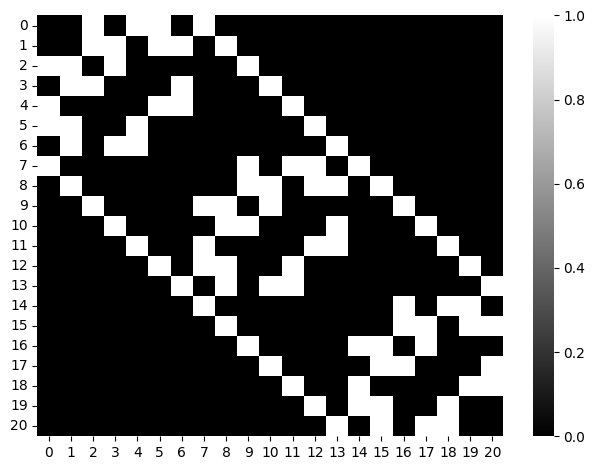

In [3]:
# Very straightforward calculation of adjacency from neighbouring voronoi cells
n_o = 7
n_b = 50
fg = FullGrid(f"cube4D_{n_b}", f"ico_{n_o}", "linspace(1, 5, 3)", use_saved=False)
voronoi_adjacency = fg.get_adjacency_of_position_grid().toarray()
sns.heatmap(voronoi_adjacency, cmap="gray")
plt.tight_layout()
plt.show()

In [4]:
# visual display with numbered Voronoi cells
fgp = FullGridPlot(fg)
ani = fgp.make_full_voronoi_plot(save=False, animate_rot=True, numbered=True)
show_anim_in_jupyter(ani)

Since distances are trivial, let's just focus on rotations (o_grid). Let us compare three methods:
- Voronoi neighbours
- polytope neighbours
- k smallest distances (different for polytope levels 0 and >= 1)

The first method is reliably correct, but not aplicable to higher dimensions. I want to compare the other two methods to the first one to see if they are reliable, since I could extend both of them to orientations.

I can compare in two ways:
- the percentage of fields in adjacency matrix that are incorrectly assigned
- the percantage of border distances that are incorrectly assigned

In [5]:
# it should ideally work perfectly at least for perfect subdivision of polyhedra
polyhedra = [IcosahedronPolytope(), Cube3DPolytope(), Cube4DPolytope()]
for poly in polyhedra:
    print(type(poly))
    print(len(poly.get_node_coordinates()))
    for i in range(2):
        poly.divide_edges()
        print(len(poly.get_node_coordinates()))

<class 'molgri.space.polytopes.IcosahedronPolytope'>
12
42
162
<class 'molgri.space.polytopes.Cube3DPolytope'>
14
50
194
<class 'molgri.space.polytopes.Cube4DPolytope'>
8
53
321


## Some examples of different sizes
This is all for icosahedron polytope. It is indeed perfectly correct if full division is done, and has some errors otherwise.

D:\HANA\phD\PAPER_2022\molecularRotationalGrids\molgri\space\fullgrid.py:116: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return nx.adjacency_matrix(valid_G, nodelist=my_nodes)
D:\HANA\phD\PAPER_2022\molecularRotationalGrids\molgri\space\fullgrid.py:116: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return nx.adjacency_matrix(valid_G, nodelist=my_nodes)
D:\HANA\phD\PAPER_2022\molecularRotationalGrids\molgri\space\fullgrid.py:116: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return nx.adjacency_matrix(valid_G, nodelist=my_nodes)


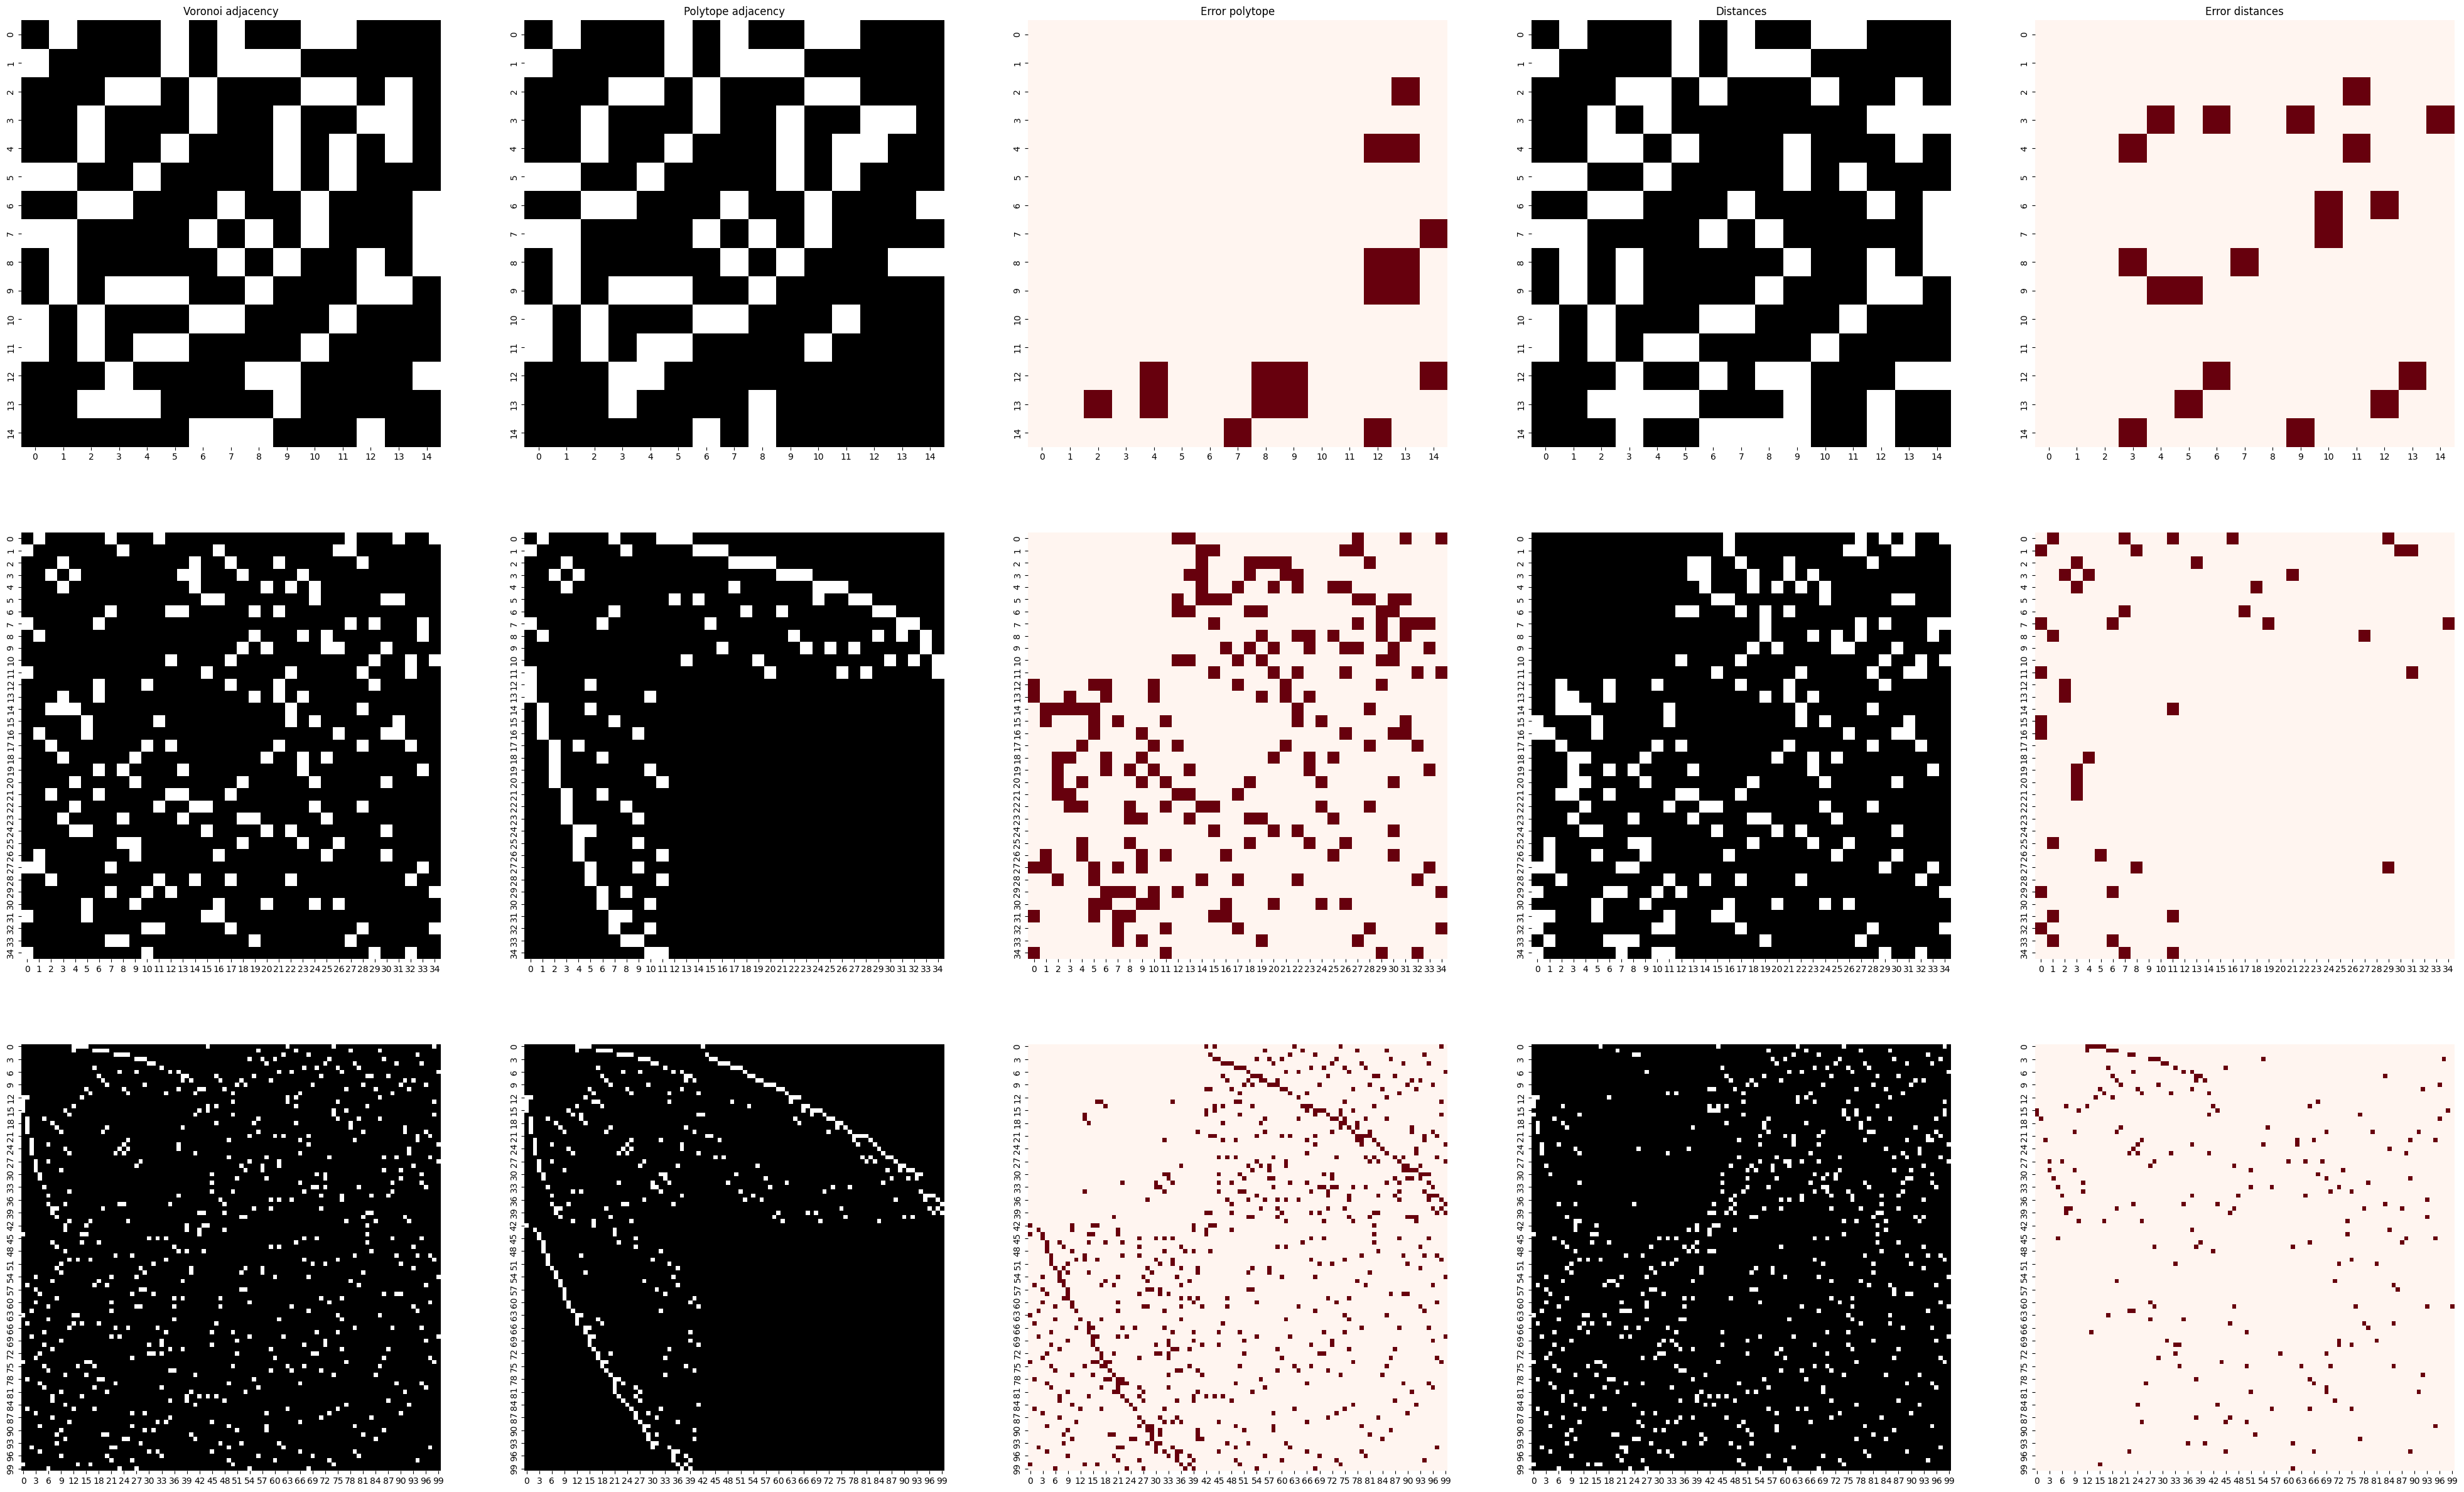

In [9]:
plt.close()
n_os = (15, 35, 100)
fig, ax = plt.subplots(len(n_os), 5, figsize=(50, 30))

for i, n_o in enumerate(n_os):
    fg = FullGrid(f"zero", f"ico_{n_o}", "[0.1,]", use_saved=False)
    vor_adj = fg.get_adjacency_of_position_grid().toarray()
    sns.heatmap(vor_adj, cmap="gray", ax=ax[i][0], cbar=False)
    poly_adj = fg.get_polyhedron_adjacency(o_grid=True).toarray()
    sns.heatmap(poly_adj, cmap="gray", ax=ax[i][1], cbar=False)
    sns.heatmap(poly_adj^vor_adj, cmap="Reds", ax=ax[i][2], cbar=False)
    empty_arr = fg.get_poly_dist_adjacency()
    sns.heatmap(empty_arr, ax=ax[i][3], cmap="gray", cbar=False)
    sns.heatmap(empty_arr^vor_adj, ax=ax[i][4], cmap="Reds", cbar=False)
ax[0][0].set_title("Voronoi adjacency")
ax[0][1].set_title("Polytope adjacency")
ax[0][2].set_title("Error polytope")
ax[0][3].set_title("Distances")
ax[0][4].set_title("Error distances")
plt.show()

In [7]:
# count the number of mismatched points + combined surfaces that are mismatched and make convergence plot
n_os_range = np.linspace(5, 50, 15, dtype=int)
num_mismatched_dist = []
amount_mismatched_dist = []
for i, n_o in enumerate(tqdm(n_os_range)):
    fg = FullGrid(f"zero", f"ico_{n_o}", "[0.1,]", use_saved=False)
    vor_adj = fg.get_adjacency_of_position_grid().toarray()
    surfaces = fg.get_full_voronoi_grid().get_all_voronoi_surfaces().toarray()
    empty_arr = fg.get_poly_dist_adjacency()
    num_mismatched_dist.append(np.sum(empty_arr^vor_adj))
    am = np.sum(np.where(empty_arr^vor_adj, surfaces, 0))
    amount_mismatched_dist.append(100*am/np.sum(surfaces))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [01:32<00:00,  6.18s/it]


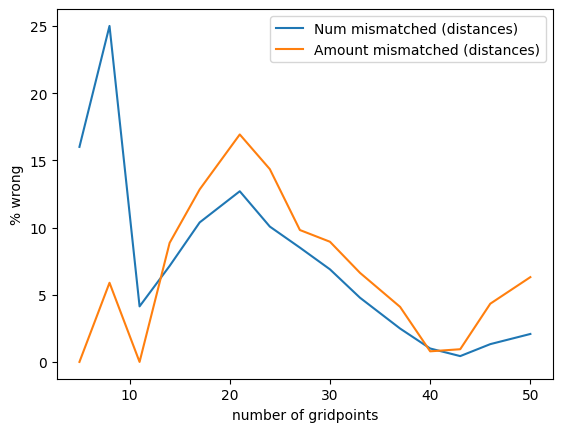

In [8]:
percent_mismatched = np.array(num_mismatched_dist)/(n_os_range**2)*100
percent_mismatched_dist = np.array(num_mismatched_dist)/(n_os_range**2)*100
sns.lineplot(x=n_os_range, y=percent_mismatched_dist, label="Num mismatched (distances)")
sns.lineplot(x=n_os_range, y=amount_mismatched_dist, label="Amount mismatched (distances)")
plt.gca().set_ylabel("% wrong")
plt.gca().set_xlabel("number of gridpoints")
plt.show()

D:\HANA\phD\PAPER_2022\molecularRotationalGrids\molgri\space\fullgrid.py:116: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return nx.adjacency_matrix(valid_G, nodelist=my_nodes)
D:\HANA\phD\PAPER_2022\molecularRotationalGrids\molgri\space\fullgrid.py:116: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return nx.adjacency_matrix(valid_G, nodelist=my_nodes)
D:\HANA\phD\PAPER_2022\molecularRotationalGrids\molgri\space\fullgrid.py:116: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return nx.adjacency_matrix(valid_G, nodelist=my_nodes)


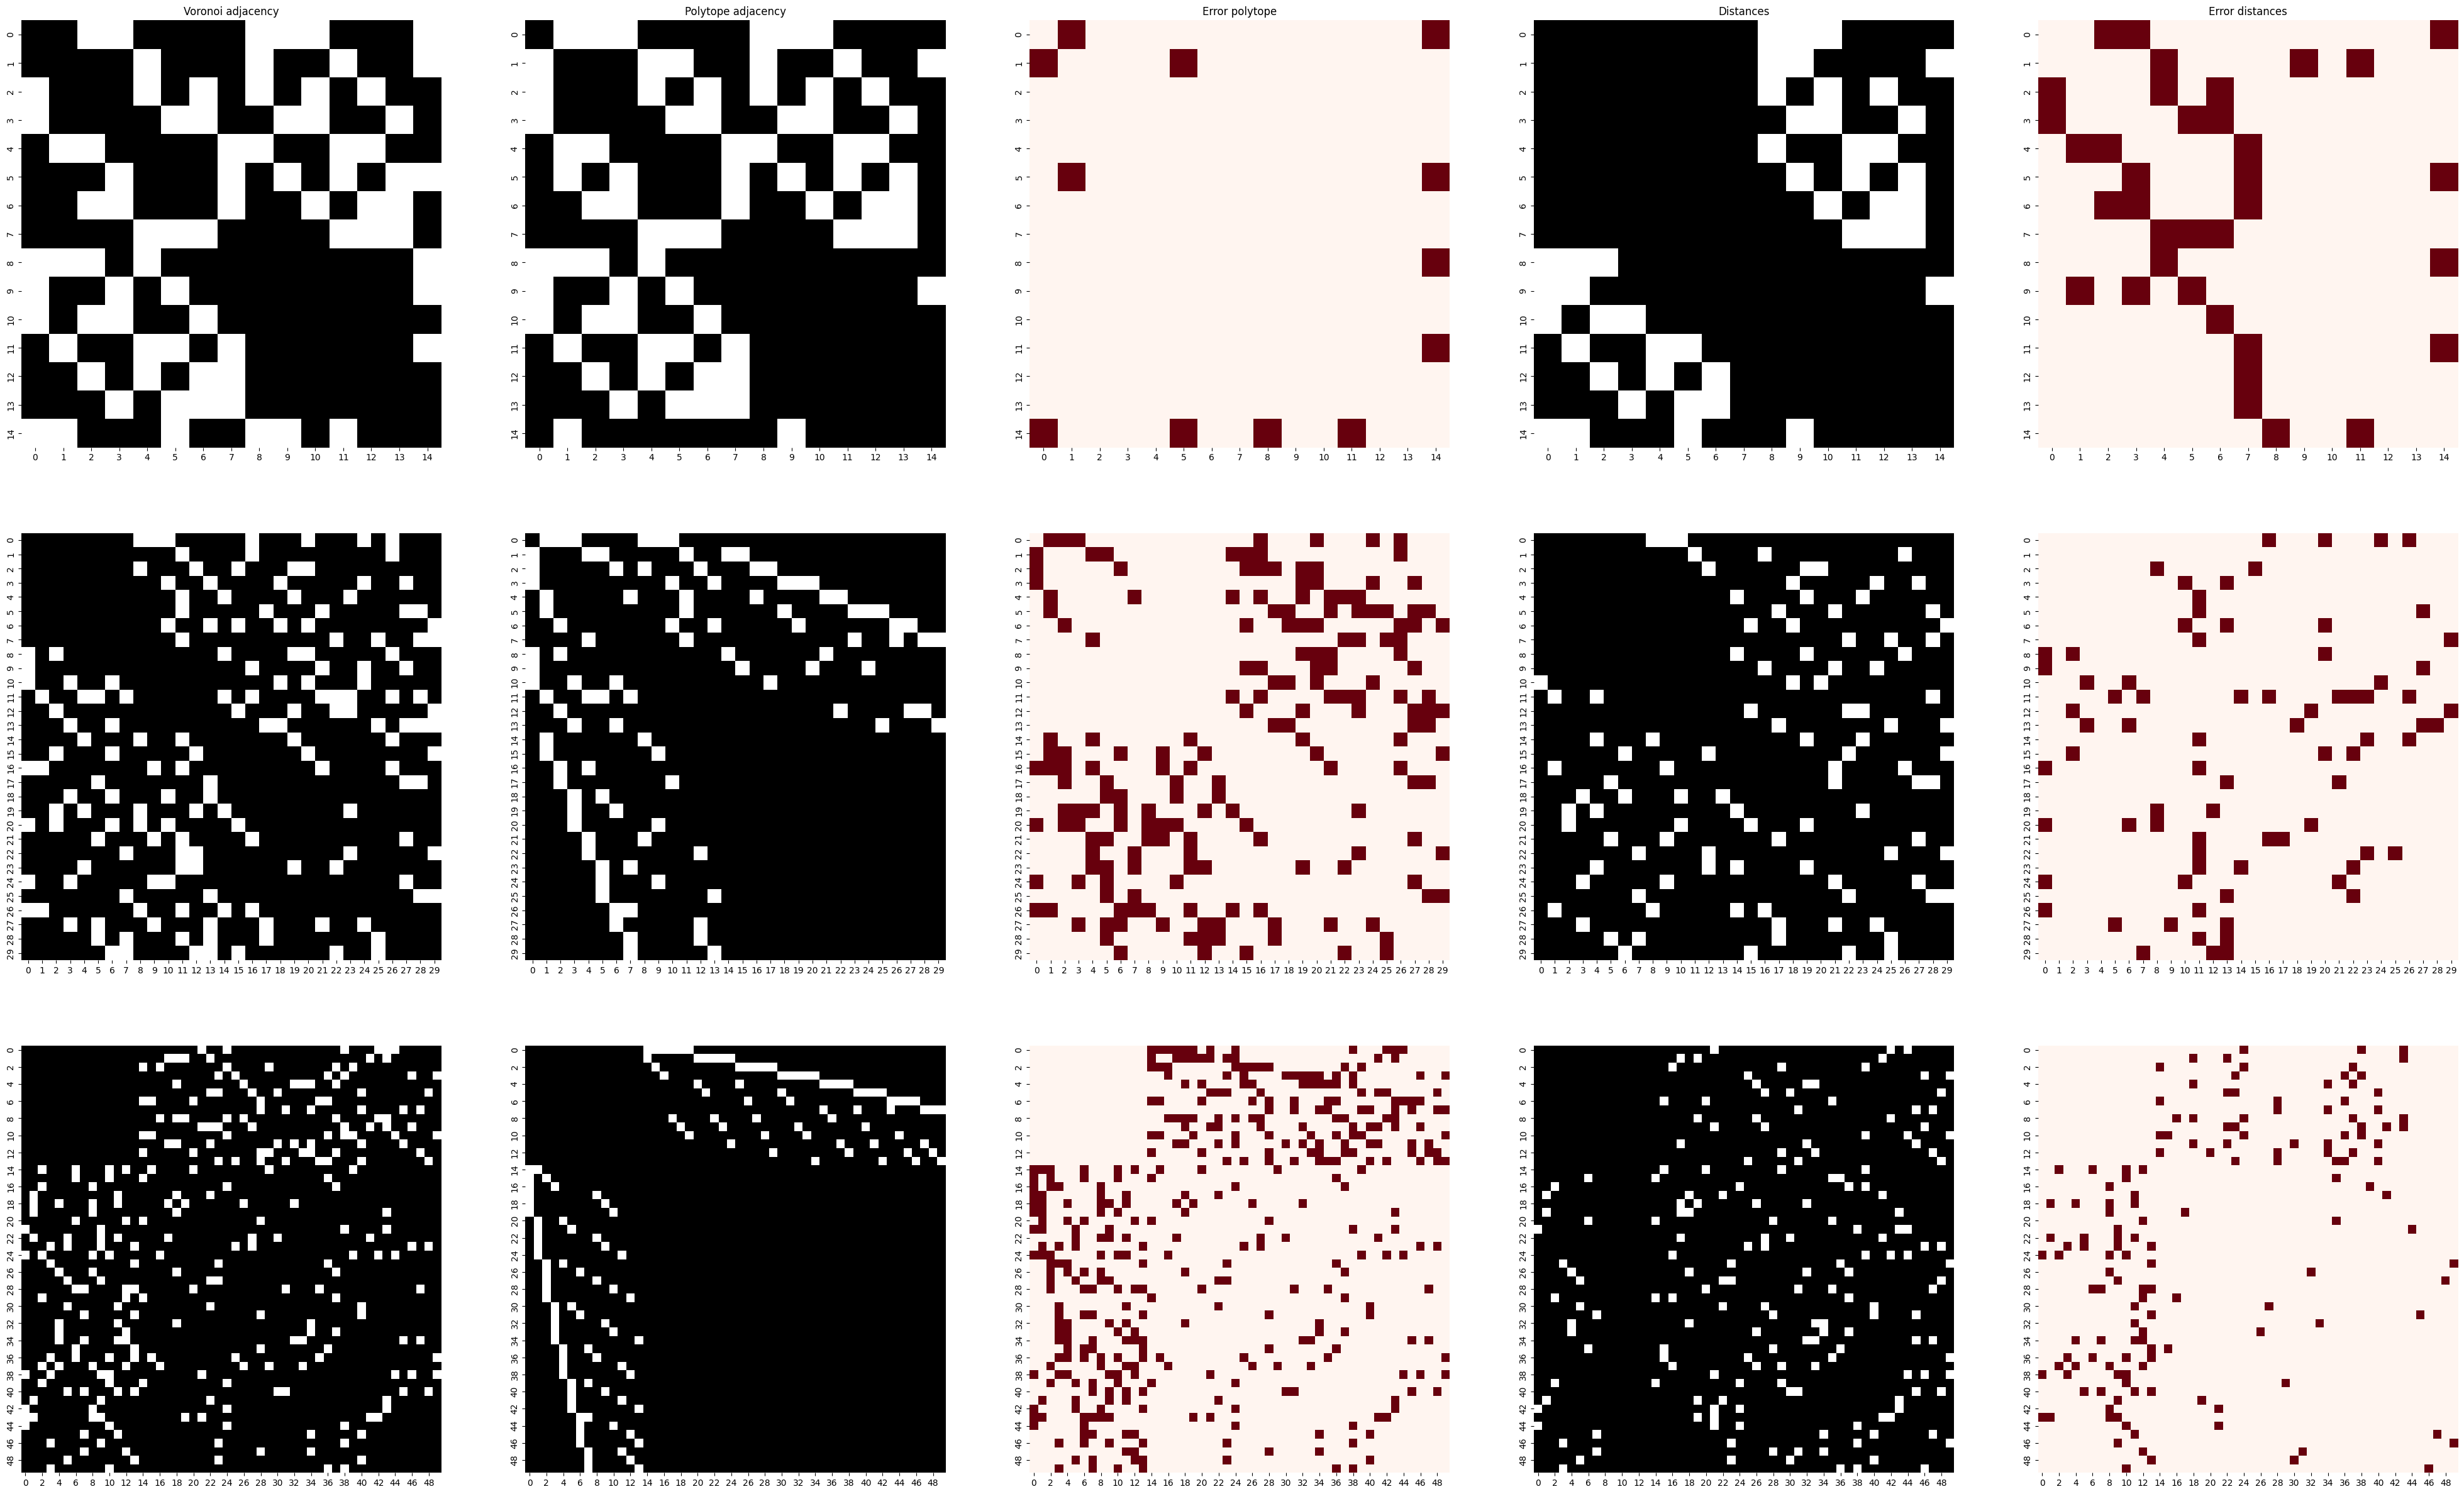

In [10]:
# repeat for cubes
plt.close()
n_os = (15, 30, 50)
fig, ax = plt.subplots(len(n_os), 5, figsize=(50, 30))
for i, n_o in enumerate(n_os):
    fg = FullGrid(f"zero", f"cube3D_{n_o}", "[0.1,]", use_saved=False)
    vor_adj = fg.get_adjacency_of_position_grid().toarray()
    sns.heatmap(vor_adj, cmap="gray", ax=ax[i][0], cbar=False)
    poly_adj = fg.get_polyhedron_adjacency(o_grid=True).toarray()
    sns.heatmap(poly_adj, cmap="gray", ax=ax[i][1], cbar=False)
    sns.heatmap(poly_adj^vor_adj, cmap="Reds", ax=ax[i][2], cbar=False)
    empty_arr = fg.get_poly_dist_adjacency()
    sns.heatmap(empty_arr, ax=ax[i][3], cmap="gray", cbar=False)
    sns.heatmap(empty_arr^vor_adj, ax=ax[i][4], cmap="Reds", cbar=False)
ax[0][0].set_title("Voronoi adjacency")
ax[0][1].set_title("Polytope adjacency")
ax[0][2].set_title("Error polytope")
ax[0][3].set_title("Distances")
ax[0][4].set_title("Error distances")
plt.show()

In [11]:
sns.set_style("white")
fig, axs = plt.subplots(1, 3, subplot_kw={"projection": "3d"}, figsize=(10, 5))
for i in range(3):
    fg = all_fg[i]
    vp = all_valid_plots[i]
    vp.make_neighbours_plot(up_to=1, node_i=13, edges=False, save=False, projected=True, fig=fig, ax=axs[i])
    ani = SphereGridPlot(fg.o_rotations).make_spherical_voronoi_plot(fig=fig, ax=axs[i],
                                                               animate_rot=True, save=False)
show_anim_in_jupyter(ani)

NameError: name 'all_fg' is not defined

In [18]:
n_os_range = np.linspace(5, 100, 30, dtype=int)
num_mismatched = []
amount_mismatched = []
num_mismatched_dist = []
amount_mismatched_dist = []
for i, n_o in enumerate(tqdm(n_os_range)):
    fg = FullGrid(f"zero", f"cube3D_{n_o}", "[0.1,]", use_saved=False)
    vor_adj = fg.get_adjacency_of_position_grid().toarray()
    poly_adj = fg.get_polyhedron_adjacency(o_grid=True).toarray()
    surfaces = fg.get_full_voronoi_grid().get_all_voronoi_surfaces().toarray()
    num_mismatched.append(np.sum(poly_adj^vor_adj))
    am = np.sum(np.where(poly_adj^vor_adj, surfaces, 0))
    amount_mismatched.append(100*am/np.sum(surfaces))
    # distances
    empty_arr = fg.get_poly_dist_adjacency()
    num_mismatched_dist.append(np.sum(empty_arr^vor_adj))
    am = np.sum(np.where(empty_arr^vor_adj, surfaces, 0))
    amount_mismatched_dist.append(100*am/np.sum(surfaces))

  0%|                                                                                                                       | 0/30 [00:00<?, ?it/s]D:\HANA\phD\PAPER_2022\molecularRotationalGrids\molgri\space\fullgrid.py:116: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return nx.adjacency_matrix(valid_G, nodelist=my_nodes)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [16:26<00:00, 32.89s/it]


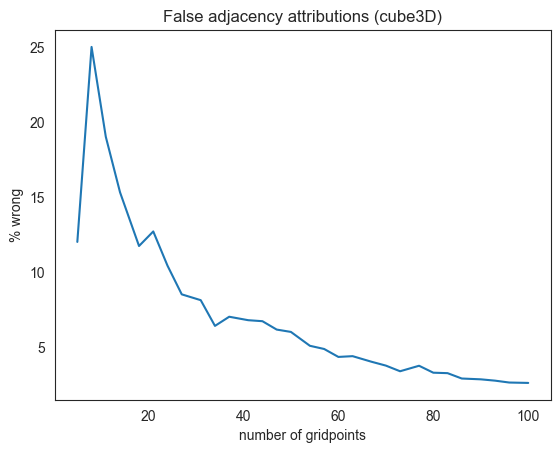

In [23]:
plt.close()
percent_mismatched = np.array(num_mismatched)/(n_os_range**2)*100
sns.lineplot(x=n_os_range, y=percent_mismatched_dist)
plt.gca().set_title("False adjacency attributions (cube3D)")
plt.gca().set_ylabel("% wrong")
plt.gca().set_xlabel("number of gridpoints")
plt.show()

In [5]:
# display which areas are thought to be neighbours by distance criterion
n_o = 35
fg = FullGrid(f"zero", f"cube3D_{n_o}", "[0.1,]", use_saved=False)
colors = ["white"] * len(fg.get_flat_position_grid())
vor_adj = fg.get_adjacency_of_position_grid().toarray()
dist_adj = fg.get_poly_dist_adjacency()
poly_adj = fg.get_polyhedron_adjacency(o_grid=True).toarray()

dist_neig = ((dist_adj[0] | poly_adj[0]) == 1)
for i, trug in enumerate(dist_neig):
    if trug:
        colors[i] = "green"
colors[0] = "blue"

fgp = FullGridPlot(fg)
ani = fgp.make_full_voronoi_plot(save=False, animate_rot=True, numbered=True, colors=colors)
show_anim_in_jupyter(ani)

Conclusion (so far): not really able to determine neighbours in any way but voronoi except for perfect divisions. Let's forcus on perfect divisions for now.

## Adjacency of orientation grids

### From distances

### From polytopes

A hypercube consists of 8 interconnected cells, each of them a cube that we subdivide in a cube4D algorithm. We later remove half of them accounting for double coverage.

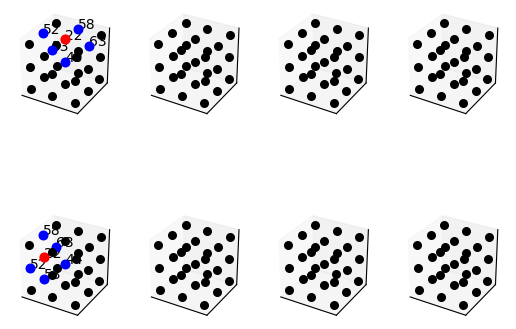

In [3]:
chosen_point = 22

c4 = Cube4DPolytope()
c4.divide_edges()
all_subpolys = c4.get_all_cells()

fig, ax = plt.subplots(2, 4, subplot_kw=dict(projection='3d'))

for i, subax in enumerate(ax.ravel()):
    pp = PolytopePlot(all_subpolys[i])
    pp.make_neighbours_plot(fig=fig, ax=subax, save=False, node_i=chosen_point, up_to=1)
plt.show()

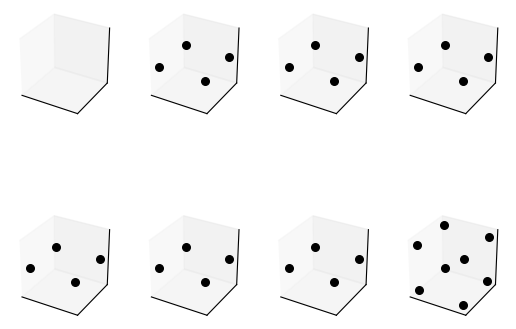

In [4]:
chosen_point = 22

c4 = Cube4DPolytope()
c4.divide_edges()
num_points = c4.G.number_of_nodes()
points = [d["projection"] for n, d in c4.G.nodes(data=True)]
points = np.array(points)
non_repeating_points = []
for i in range(4):
    for point in points:
        if np.allclose(point[:i], 0) and point[i] > 0:
            non_repeating_points.append(tuple(point))

all_subpolys = c4.get_all_cells(include_only=non_repeating_points)

fig, ax = plt.subplots(2, 4, subplot_kw=dict(projection='3d'))

for i, subax in enumerate(ax.ravel()):
    pp = PolytopePlot(all_subpolys[i])
    pp.make_neighbours_plot(fig=fig, ax=subax, save=False, node_i=chosen_point, up_to=1)
plt.show()

Now we exclude half of the points because quaternions work like that

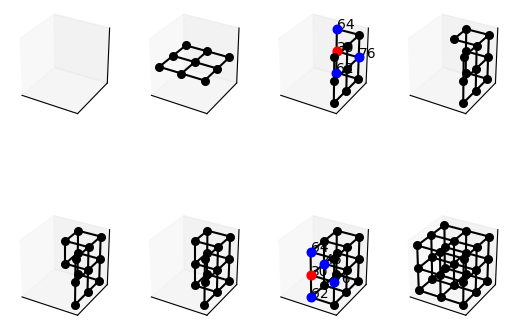

In [5]:
chosen_point = 30

c4 = Cube4DPolytope()
c4.divide_edges()
num_points = c4.G.number_of_nodes()
points_dic = c4.G.nodes(data=True)

non_repeating_points = []
for i in range(4):
    for k, v in points_dic:
        if np.allclose(v["projection"][:i], 0) and v["projection"][i] > 0:
            non_repeating_points.append(k)
all_subpolys = c4.get_all_cells(include_only=non_repeating_points)

fig, ax = plt.subplots(2, 4, subplot_kw=dict(projection='3d'))

for i, subax in enumerate(ax.ravel()):
    pp = PolytopePlot(all_subpolys[i])
    pp.make_neighbours_plot(fig=fig, ax=subax, save=False, node_i=chosen_point, up_to=1, edges=True)
plt.show()

Still need to convert to an adjacency matrix

C:\Users\Hana\AppData\Local\Temp\ipykernel_17344\2420329808.py:2: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_matrix = nx.adjacency_matrix(subgraph_valid_q, nodelist=sorted(subgraph_valid_q.nodes(), key=lambda n: subgraph_valid_q.nodes[n]['central_index'])).toarray()


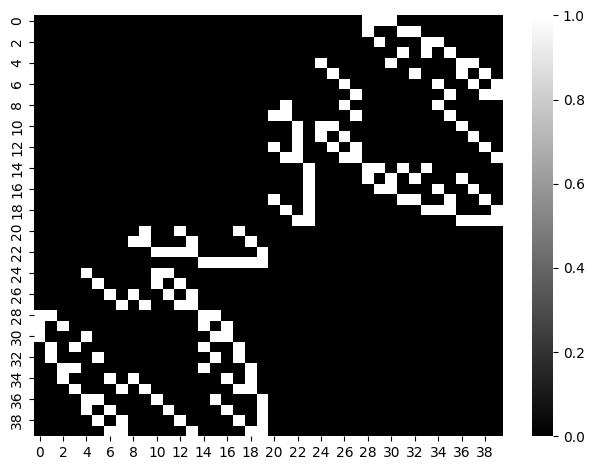

Number of neigbours per quaternion: [3 3 3 3 4 4 4 4 3 4 4 4 5 5 5 5 5 6 6 6 3 4 5 6 3 3 4 4 4 4 4 4 4 4 5 5 5
 5 5 5]


In [15]:
subgraph_valid_q = c4.G.subgraph(nodes=non_repeating_points)
adj_matrix = nx.adjacency_matrix(subgraph_valid_q, nodelist=sorted(subgraph_valid_q.nodes(), key=lambda n: subgraph_valid_q.nodes[n]['central_index'])).toarray()
sns.heatmap(adj_matrix, cmap="gray")
plt.tight_layout()
plt.show()
print(f"Number of neigbours per quaternion: {np.sum(adj_matrix, axis=0)}")

Repeat the same plot using distances between quaternions

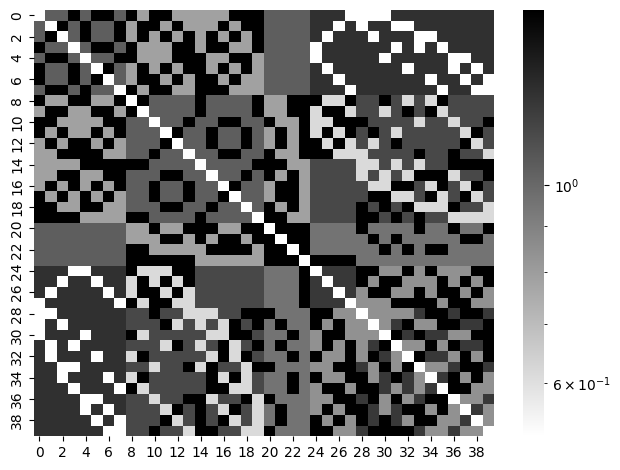

In [29]:
import matplotlib.colors as colors
projected_nodes = sorted(subgraph_valid_q.nodes, key=lambda n: subgraph_valid_q.nodes[n]['central_index'])
projected_nodes = np.array([subgraph_valid_q.nodes[n]['projection'] for n in projected_nodes])

def constrained_angle_distance(q1, q2):
    theta = angle_between_vectors(q1, q2)
    if (theta > pi / 2):
        theta = pi - theta
    return theta

cdistances = cdist(projected_nodes, projected_nodes, constrained_angle_distance)
sns.heatmap(cdistances, cmap="gray_r", norm=colors.LogNorm())
plt.tight_layout()
plt.show()


## Combined Adjacency

Points are adjacent if same point on position grid and neighbours on orientation grid; OR neighbours on position gris and same point on orientation grid.